In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [53]:
# 서비스 계정 키 경로 설정
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/home/eunyu/sprintda05-eunyu-a9946f7dea9c.json"
# GCS의 Parquet 파일 경로
gcs_path = 'gs://final_project_enuyu/data/final_project/votes/accounts_failpaymenthistory.parquet'

# 데이터 불러오기
failpaymenthistory_df = pd.read_parquet(gcs_path, engine='pyarrow')
failpaymenthistory_df

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730
...,...,...,...,...,...
158,170,heart.777,A,2023-07-28 08:31:19,1254708
159,171,None,I,2023-08-12 11:26:59,1556867
160,172,heart.777,A,2023-08-14 23:47:46,1282373
161,173,None,I,2023-09-17 09:12:53,927108


In [54]:
failpaymenthistory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          163 non-null    int64         
 1   productId   56 non-null     object        
 2   phone_type  163 non-null    object        
 3   created_at  163 non-null    datetime64[ns]
 4   user_id     163 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.5+ KB


In [55]:
failpaymenthistory_df.describe()

,id,created_at,user_id
count,163.000000,163,1.630000e+02
mean,89.828221,2023-05-27 11:32:20.828220672,1.263685e+06
min,6.000000,2023-05-14 05:49:22,8.341120e+05
25%,48.500000,2023-05-18 11:34:05,1.152704e+06
50%,89.000000,2023-05-22 08:54:33,1.273301e+06
75%,131.500000,2023-05-29 12:58:21.500000,1.398432e+06
max,174.000000,2023-09-17 09:12:53,1.575434e+06
std,48.494316,NaN,1.824636e+05


In [56]:
failpaymenthistory_df.isnull().mean().sort_values(ascending=False) * 100

productId     65.644172
id             0.000000
phone_type     0.000000
created_at     0.000000
user_id        0.000000
dtype: float64

In [57]:
categorical_cols = failpaymenthistory_df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    print(f"\n [{col}] 분포")
    print(failpaymenthistory_df[col].value_counts(dropna=False))


 [productId] 분포
productId
None          107
heart.777      49
heart.1000      4
heart.200       3
Name: count, dtype: int64

 [phone_type] 분포
phone_type
I    107
A     56
Name: count, dtype: int64


In [58]:
numerical_cols = failpaymenthistory_df.select_dtypes(include=['int64', 'float64']).columns

In [59]:
# IQR 기반 이상치 개수 확인
for col in numerical_cols:
    Q1 = failpaymenthistory_df[col].quantile(0.25)
    Q3 = failpaymenthistory_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = failpaymenthistory_df[(failpaymenthistory_df[col] < Q1 - 1.5 * IQR) |
                                     (failpaymenthistory_df[col] > Q3 + 1.5 * IQR)]
    print(f"{col}: 이상치 개수 = {len(outliers)}")


id: 이상치 개수 = 0
user_id: 이상치 개수 = 0


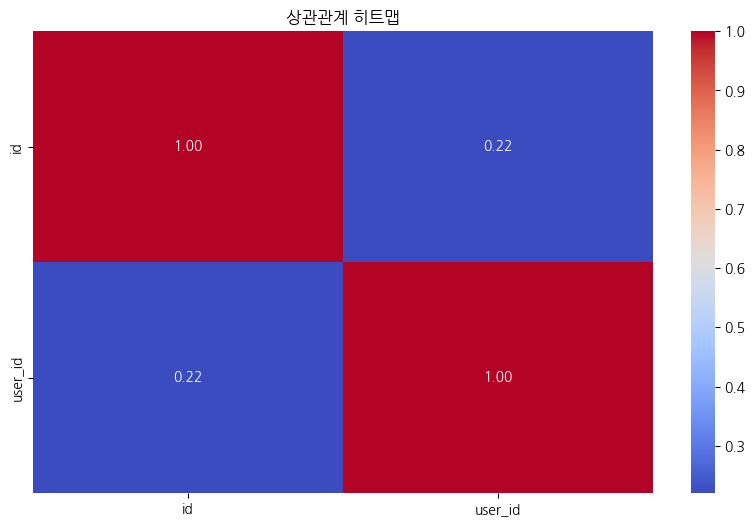

In [60]:
plt.figure(figsize=(10, 6))
sns.heatmap(failpaymenthistory_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("상관관계 히트맵")
plt.show()

In [61]:
# 날짜형 컬럼 확인
datetime_cols = failpaymenthistory_df.select_dtypes(include=['datetime64[ns]', 'datetime']).columns
print("날짜형 컬럼:", list(datetime_cols))

# 예시: 날짜 파생 변수 생성
if len(datetime_cols) > 0:
    dt_col = datetime_cols[0]
    failpaymenthistory_df['year'] = failpaymenthistory_df[dt_col].dt.year
    failpaymenthistory_df['month'] = failpaymenthistory_df[dt_col].dt.month
    failpaymenthistory_df['dayofweek'] = failpaymenthistory_df[dt_col].dt.dayofweek
    print(failpaymenthistory_df[['year', 'month', 'dayofweek']].head())


날짜형 컬럼: ['created_at']
   year  month  dayofweek
0  2023      5          6
1  2023      5          6
2  2023      5          6
3  2023      5          6
4  2023      5          6


#### 1. 유저별 실패 결제 건수 집계

In [62]:
user_fail_count = failpaymenthistory_df['user_id'].value_counts().reset_index()
user_fail_count.columns = ['user_id', 'fail_count']

print("상위 10명 유저의 실패 결제 횟수:")
display(user_fail_count.head(10))


상위 10명 유저의 실패 결제 횟수:


,user_id,fail_count
0,927108,2
1,1211047,2
2,1322662,2
3,1236620,1
4,1129520,1
5,1464003,1
6,1310450,1
7,1505705,1
8,1297332,1
9,1298182,1


#### 2. 유저별 첫 실패일 / 마지막 실패일

In [63]:
print(failpaymenthistory_df.columns)

Index(['id', 'productId', 'phone_type', 'created_at', 'user_id', 'year',
       'month', 'dayofweek'],
      dtype='object')


In [64]:
# created_at을 기준으로 분석
failpaymenthistory_df['created_at'] = pd.to_datetime(failpaymenthistory_df['created_at'], errors='coerce')

user_date_range = failpaymenthistory_df.groupby('user_id')['created_at'].agg(['min', 'max']).reset_index()
user_date_range.columns = ['user_id', 'first_fail_date', 'last_fail_date']

print("유저별 첫/마지막 실패 결제일:")
display(user_date_range.head())



유저별 첫/마지막 실패 결제일:


,user_id,first_fail_date,last_fail_date
0,834112,2023-05-21 23:55:48,2023-05-21 23:55:48
1,877422,2023-05-24 06:49:30,2023-05-24 06:49:30
2,878664,2023-05-16 13:51:35,2023-05-16 13:51:35
3,892843,2023-05-30 13:22:05,2023-05-30 13:22:05
4,894196,2023-06-04 15:01:04,2023-06-04 15:01:04


#### 3. 상위 1% 유저가 전체 실패의 몇 %를 차지하는가?

In [65]:
# 유저 수 상위 1%
n_users = len(user_fail_count)
top_1_percent_threshold = int(n_users * 0.01)

top_users = user_fail_count.head(top_1_percent_threshold)
top_users_total_fails = top_users['fail_count'].sum()
total_fails = len(failpaymenthistory_df)

print(f"상위 1% 유저 수: {top_1_percent_threshold}")
print(f"상위 1% 유저가 차지하는 실패 결제 비중: {top_users_total_fails / total_fails * 100:.2f}%")

상위 1% 유저 수: 1
상위 1% 유저가 차지하는 실패 결제 비중: 1.23%


#### 4. 실패 건수 1회 vs 다회 유저 분포

유저별 실패 건수 분포:
fail_count
1    157
2      3
Name: count, dtype: int64


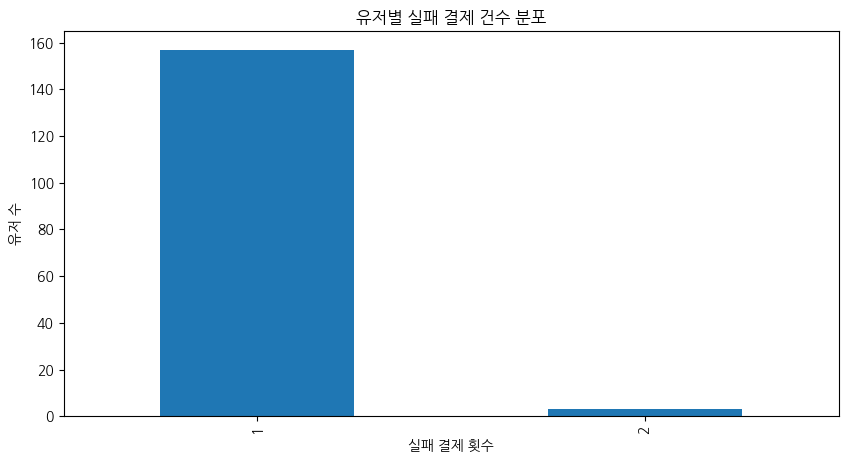

In [66]:
fail_distribution = user_fail_count['fail_count'].value_counts().sort_index()
print("유저별 실패 건수 분포:")
print(fail_distribution)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
fail_distribution.plot(kind='bar')
plt.title("유저별 실패 결제 건수 분포")
plt.xlabel("실패 결제 횟수")
plt.ylabel("유저 수")
plt.show()


#### 유저 생애주기 중 언제 실패가 잦은지

In [67]:
# created_at은 실패 결제 발생일
failpaymenthistory_df['created_at'] = pd.to_datetime(failpaymenthistory_df['created_at'], errors='coerce')

# 유저별 첫 실패일을 merge
user_first_fail = user_date_range[['user_id', 'first_fail_date']]
failpaymenthistory_df = failpaymenthistory_df.merge(user_first_fail, on='user_id', how='left')

# 생애주기 일수 (life_day) 계산
failpaymenthistory_df['life_day'] = (failpaymenthistory_df['created_at'] - failpaymenthistory_df['first_fail_date']).dt.days


In [68]:
# 생애주기 구간 설정
bins = [-1, 7, 30, 90, 180, 365, 10000]
labels = ['0~7일', '8~30일', '31~90일', '91~180일', '181~365일', '1년 이상']

failpaymenthistory_df['life_stage'] = pd.cut(failpaymenthistory_df['life_day'], bins=bins, labels=labels)


In [69]:
# 구간별 실패 건수 집계
life_stage_counts = failpaymenthistory_df['life_stage'].value_counts().sort_index()

print("생애주기 구간별 실패 결제 수:")
print(life_stage_counts)


생애주기 구간별 실패 결제 수:
life_stage
0~7일        163
8~30일         0
31~90일        0
91~180일       0
181~365일      0
1년 이상         0
Name: count, dtype: int64


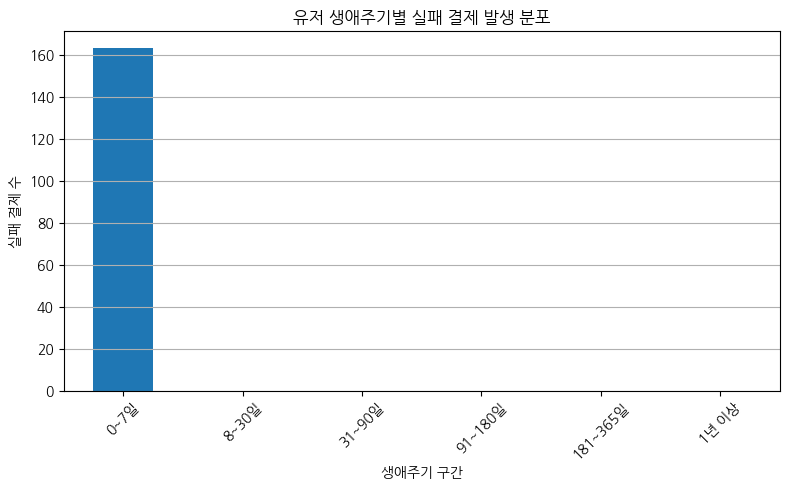

In [70]:

plt.figure(figsize=(8, 5))
life_stage_counts.plot(kind='bar')
plt.title("유저 생애주기별 실패 결제 발생 분포")
plt.xlabel("생애주기 구간")
plt.ylabel("실패 결제 수")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
